In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import re
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import netCDF4 as nc

from sqlalchemy.sql import select, and_, or_, not_, func
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey, desc
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from time import strptime
import string
import pandas as pd
from dateutil.parser import parse as dutparse

%matplotlib inline

In [11]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'ECBuoy/'
dbname='ECBuoy'
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
FBuoyTBL=Base.classes.FBuoyTBL
FlowTBL=Base.classes.FlowTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [3]:
turbstart=session.query(FlowTBL.DecDay).filter(FlowTBL.MeanTurb>0).order_by(FlowTBL.DecDay).first()
print(turbstart)

(39812,)


In [4]:
dt.datetime(1900,1,1)+dt.timedelta(days=turbstart[0])

datetime.datetime(2009, 1, 1, 0, 0)

In [14]:
df=pd.DataFrame(session.query(FlowTBL.DecDay,FlowTBL.RateHope,FlowTBL.MeanTurb).filter(FlowTBL.DecDay>39800).all())
df.columns = ['DecDay', 'RateHope', 'MeanTurb']

In [16]:
dts=[dt.datetime(1900,1,1)+dt.timedelta(days=ii) for ii in df['DecDay']]

In [17]:
df.head(20)

,DecDay,RateHope,MeanTurb
0,39801,688.0,NaN
1,39802,729.0,NaN
2,39803,930.0,NaN
3,39804,818.0,NaN
4,39805,750.0,NaN
5,39806,770.0,NaN
6,39807,810.0,NaN
7,39808,845.0,NaN
8,39809,900.0,NaN
9,39810,933.0,NaN


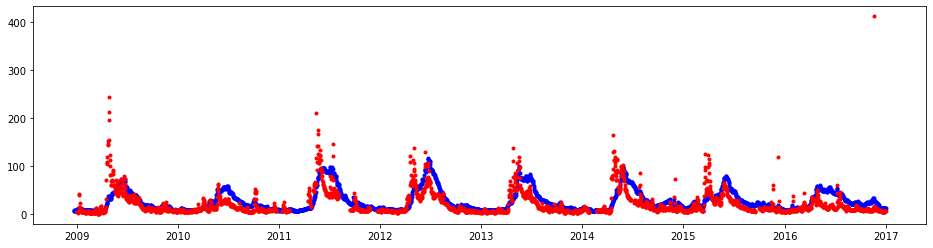

In [19]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dts,df['RateHope']*1e-2,'b.')
ax.plot(dts,df['MeanTurb'],'r.');

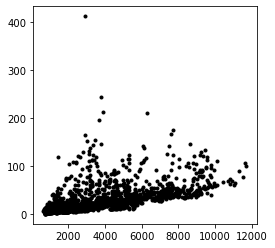

In [20]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(df['RateHope'],df['MeanTurb'],'k.');

In [21]:
def gsmooth2(times,Fvals,Tvals,L):
    tcrop=times[(~np.isnan(times))&(~np.isnan(Fvals))&(~np.isnan(Tvals))]
    outtimes=np.arange(tcrop[0],tcrop[-1])
    outvalsF=np.empty(np.shape(outtimes))
    outvalsT=np.empty(np.shape(outtimes))
    outwghtsF=np.empty(np.shape(outtimes))
    outwghtsT=np.empty(np.shape(outtimes))
    s=L/2.355
    sdict={}
    for ii in range(0,len(outtimes)):
        t=outtimes[ii]
        diff=[abs(x-t) for x in times]
        weight=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff]
        outvalsF[ii]=np.nansum(weight*Fvals)/np.sum(weight*np.array([int(i) for i in ~np.isnan(Fvals)]))
        outvalsT[ii]=np.nansum(weight*Tvals)/np.sum(weight*np.array([int(i) for i in ~np.isnan(Tvals)]))
        outwghtsF[ii]=np.sum(weight*np.array([int(i) for i in ~np.isnan(Fvals)]))
        outwghtsT[ii]=np.sum(weight*np.array([int(i) for i in ~np.isnan(Tvals)]))
        #summed weight of 5.3 seems like a good cutoff; close to max for L=5; use .99*max
    return(outtimes,np.where(outwghtsF>.99*np.max(outwghtsF),outvalsF,np.nan),np.where(outwghtsT>.99*np.max(outwghtsF),outvalsT,np.nan),outwghtsF,outwghtsT)

In [22]:
tt1,F1,T1,wF1,wT1=gsmooth2(df['DecDay'].values,df['RateHope'].values,df['MeanTurb'].values,2)
dts1=[dt.datetime(1900,1,1)+dt.timedelta(days=int(i)) for i in tt1]

<ipython-input-21-a2f326ff3abb>:15: RuntimeWarning: invalid value encountered in double_scalars
  outvalsT[ii]=np.nansum(weight*Tvals)/np.sum(weight*np.array([int(i) for i in ~np.isnan(Tvals)]))


In [23]:
tt2,F2,T2,wF2,wT2=gsmooth2(df['DecDay'].values,df['RateHope'].values,df['MeanTurb'].values,33)
dts2=[dt.datetime(1900,1,1)+dt.timedelta(days=int(i)) for i in tt2]

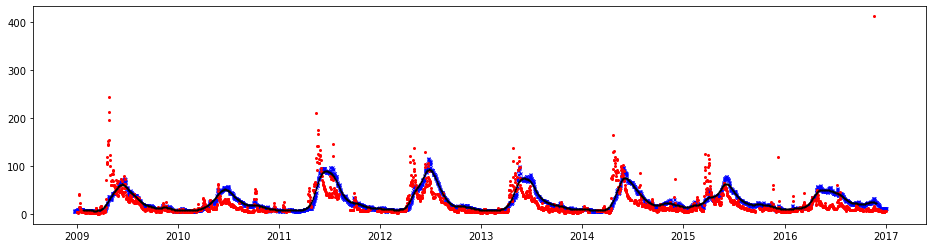

In [24]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dts,df['RateHope']*1e-2,'bx',ms=3)
ax.plot(dts,df['MeanTurb'],'ro',ms=2)
ax.plot(dts1,F2*1e-2,'k.',ms=1);
#ax.plot(dts1,wF1*100,'c+')

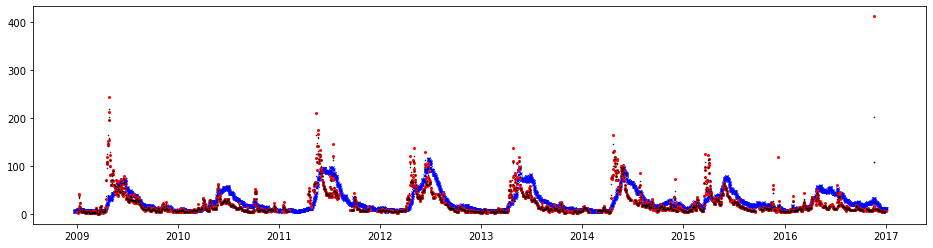

In [25]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dts,df['RateHope']*1e-2,'bx',ms=3)
ax.plot(dts,df['MeanTurb'],'ro',ms=2)
ax.plot(dts1,T1,'k.',ms=1);
#ax.plot(dts1,wT1*100,'c+')

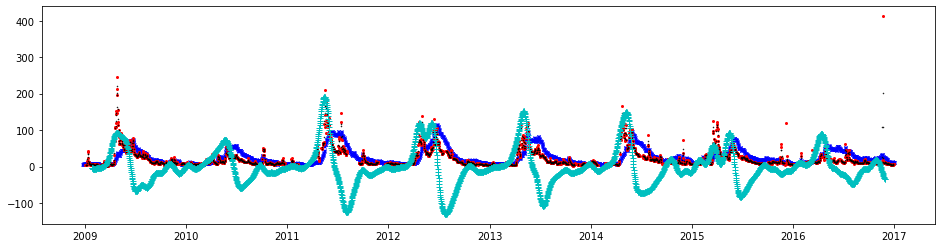

In [26]:
dFdt=(F2[1:]-F2[:-1])/(tt1[1:]-tt1[:-1])
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dts,df['RateHope']*1e-2,'bx',ms=3)
ax.plot(dts,df['MeanTurb'],'ro',ms=2)
ax.plot(dts1,T1,'k.',ms=1)
ax.plot(dts1[1:],dFdt,'c+');

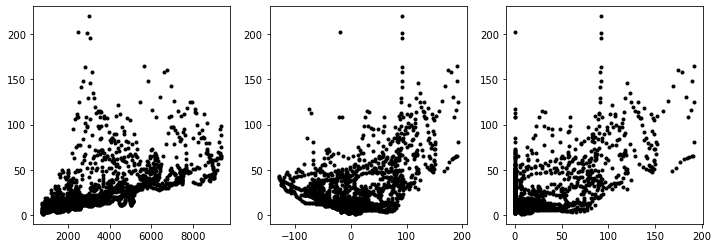

In [27]:
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(F2,T1,'k.')
ax[1].plot(dFdt,T1[1:],'k.')
ax[2].plot([max(ff,0) for ff in dFdt],T1[1:],'k.');

In [28]:
# match unfiltered turbidity to filtered flow time vector:
Tu=np.array([df.loc[df.DecDay==elt,['MeanTurb']].values[0][0] for elt in tt2])

In [29]:
# match unfiltered turbidity to filtered flow time vector:
Fu=np.array([df.loc[df.DecDay==elt,['RateHope']].values[0][0] for elt in tt2])

In [30]:
F2

array([nan, nan, nan, ..., nan, nan, nan])

[0.00766221 0.33650788]
21.18279628515923


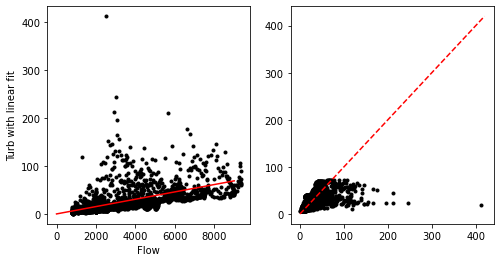

In [31]:
ii=(~np.isnan(Tu))&(~np.isnan(F2))
ii[0]=False # make sure; it will be cut off
a=np.vstack([F2[ii],np.ones(len(Tu[ii]))]).T
m = np.linalg.lstsq(a,Tu[ii],rcond=None)[0]
print(m)
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(F2,Tu,'k.')
ax[0].plot(np.arange(0,10000,1000),m[0]*np.arange(0,10000,1000)+m[1],'r-')
ax[0].set_xlabel('Flow')
ax[0].set_ylabel('Turb with linear fit')
resid=Tu[ii]-np.dot(a,m)
SSE=np.sqrt(np.dot((Tu[ii]-np.dot(a,m)),(Tu[ii]-np.dot(a,m)).T)/len(Tu[ii]))
print(SSE)
ax[1].plot(Tu[ii],np.dot(a,m),'k.')
ax[1].plot((0,420),(0,420),'r--');

[0.00738426 1.02491422]
20.427928579420215


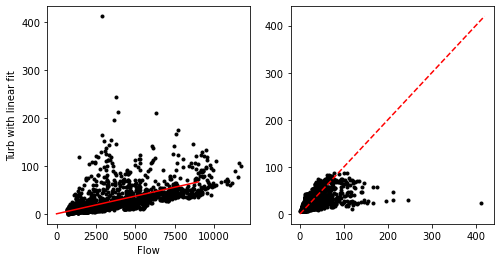

In [32]:
ii=(~np.isnan(Tu))&(~np.isnan(Fu))
ii[0]=False # make sure; it will be cut off
a=np.vstack([Fu[ii],np.ones(len(Tu[ii]))]).T
m = np.linalg.lstsq(a,Tu[ii],rcond=None)[0]
print(m)
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(Fu,Tu,'k.')
ax[0].plot(np.arange(0,10000,1000),m[0]*np.arange(0,10000,1000)+m[1],'r-')
ax[0].set_xlabel('Flow')
ax[0].set_ylabel('Turb with linear fit')
resid=Tu[ii]-np.dot(a,m)
SSE=np.sqrt(np.dot((Tu[ii]-np.dot(a,m)),(Tu[ii]-np.dot(a,m)).T)/len(Tu[ii]))
print(SSE)
ax[1].plot(Tu[ii],np.dot(a,m),'k.')
ax[1].plot((0,420),(0,420),'r--');

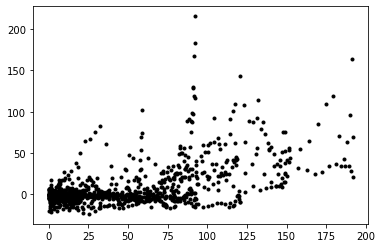

In [33]:
dFdtmatch=dFdt[ii[1:]]
ii2=dFdtmatch>0
plt.plot(dFdtmatch[ii2],resid[ii2],'k.');

[ 0.00573075  0.34009036 -0.34208405]
17.68937810038783


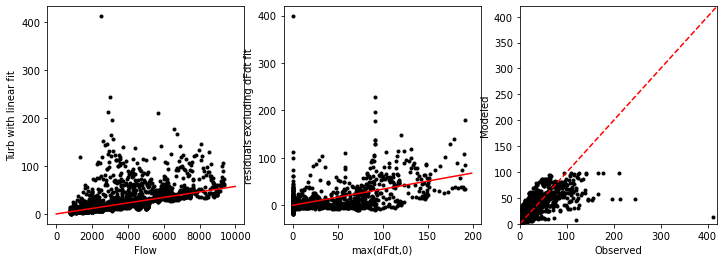

In [34]:
iTu=Tu[1:]; iF2=F2[1:];
ii=(~np.isnan(iTu))&(~np.isnan(iF2)&(~np.isnan(dFdt)))
dFdtP=np.array([max(iv,0) for iv in dFdt])
a=np.vstack([iF2[ii],dFdtP[ii],np.ones(len(iTu[ii]))]).T
m = np.linalg.lstsq(a,iTu[ii],rcond=None)[0]
print(m)
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(F2,Tu,'k.')
ax[0].plot(np.arange(0,11000,1000),m[0]*np.arange(0,11000,1000)+m[1],'r-')
ax[0].set_xlabel('Flow')
ax[0].set_ylabel('Turb with linear fit')
resid=iTu[ii]-np.dot(a,m)
SSE=np.sqrt(np.dot((iTu[ii]-np.dot(a,m)),(iTu[ii]-np.dot(a,m)).T)/len(iTu[ii]))
print(SSE)
resid2=iTu[ii]-(m[0]*iF2[ii]+m[2])
ax[1].plot(dFdtP[ii],resid2,'k.')
ax[1].set_xlabel('max(dFdt,0)')
ax[1].set_ylabel('residuals excluding dFdt fit')
ax[1].plot(np.arange(0,200),m[1]*np.arange(0,200),'r-')
ax[2].plot(iTu[ii],np.dot(a,m),'k.')
ax[2].set_xlim(0,420)
ax[2].set_ylim(0,420)
ax[2].set_xlabel('Observed')
ax[2].set_ylabel('Modeled')
ax[2].plot((0,420),(0,420),'r--');

[ 0.00575474  0.34071164 -0.47925858]
16.89694950261107


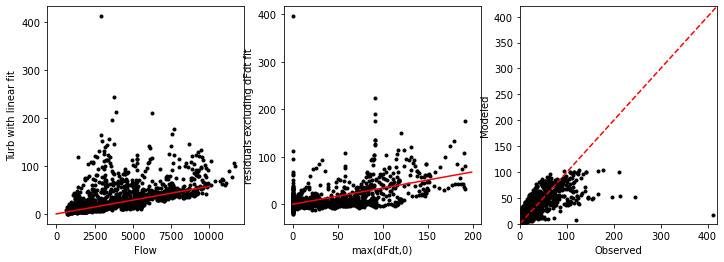

In [35]:
iTu=Tu[1:]; iFu=Fu[1:];
ii=(~np.isnan(iTu))&(~np.isnan(iFu)&(~np.isnan(dFdt)))
dFdtP=np.array([max(iv,0) for iv in dFdt])
a=np.vstack([iFu[ii],dFdtP[ii],np.ones(len(iTu[ii]))]).T
m1 = np.linalg.lstsq(a,iTu[ii],rcond=None)[0]
print(m1)
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(Fu,Tu,'k.')
ax[0].plot(np.arange(0,11000,1000),m1[0]*np.arange(0,11000,1000)+m1[1],'r-')
ax[0].set_xlabel('Flow')
ax[0].set_ylabel('Turb with linear fit')
resid=iTu[ii]-np.dot(a,m1)
SSE=np.sqrt(np.dot((iTu[ii]-np.dot(a,m1)),(iTu[ii]-np.dot(a,m1)).T)/len(iTu[ii]))
print(SSE)
resid2=iTu[ii]-(m1[0]*iFu[ii]+m1[2])
ax[1].plot(dFdtP[ii],resid2,'k.')
ax[1].set_xlabel('max(dFdt,0)')
ax[1].set_ylabel('residuals excluding dFdt fit')
ax[1].plot(np.arange(0,200),m1[1]*np.arange(0,200),'r-')
ax[2].plot(iTu[ii],np.dot(a,m1),'k.')
ax[2].set_xlim(0,420)
ax[2].set_ylim(0,420)
ax[2].set_xlabel('Observed')
ax[2].set_ylabel('Modeled')
ax[2].plot((0,420),(0,420),'r--');

[0.00588415 0.00257168 1.22707881]
17.85861729424384


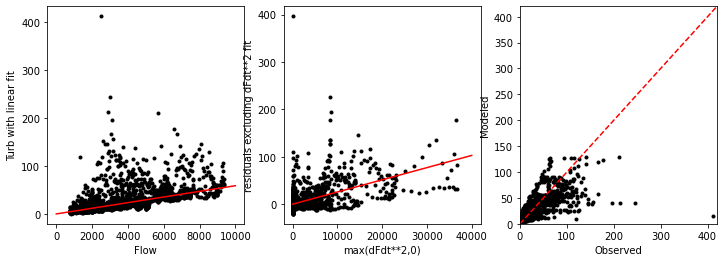

In [36]:
iTu=Tu[1:]; iF2=F2[1:];
ii=(~np.isnan(iTu))&(~np.isnan(iF2)&(~np.isnan(dFdt)))
dFdtP=np.array([max(iv,0) for iv in dFdt])
a=np.vstack([iF2[ii],dFdtP[ii]*dFdtP[ii],np.ones(len(iTu[ii]))]).T
m = np.linalg.lstsq(a,iTu[ii],rcond=None)[0]
print(m)
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(F2,Tu,'k.')
ax[0].plot(np.arange(0,11000,1000),m[0]*np.arange(0,11000,1000)+m[1],'r-')
ax[0].set_xlabel('Flow')
ax[0].set_ylabel('Turb with linear fit')
resid=iTu[ii]-np.dot(a,m)
SSE=np.sqrt(np.dot((iTu[ii]-np.dot(a,m)),(iTu[ii]-np.dot(a,m)).T)/len(iTu[ii]))
print(SSE)
resid2=iTu[ii]-(m[0]*iF2[ii]+m[2])
ax[1].plot(dFdtP[ii]*dFdtP[ii],resid2,'k.')
ax[1].set_xlabel('max(dFdt**2,0)')
ax[1].set_ylabel('residuals excluding dFdt**2 fit')
ax[1].plot(np.arange(0,200**2),m[1]*np.arange(0,200**2),'r-')
ax[2].plot(iTu[ii],np.dot(a,m),'k.')
ax[2].set_xlim(0,420)
ax[2].set_ylim(0,420)
ax[2].set_xlabel('Observed')
ax[2].set_ylabel('Modeled')
ax[2].plot((0,420),(0,420),'r--');

## use fit to F and dFdt

[ 0.00573075  0.34009036 -0.34208405]
17.68937810038783


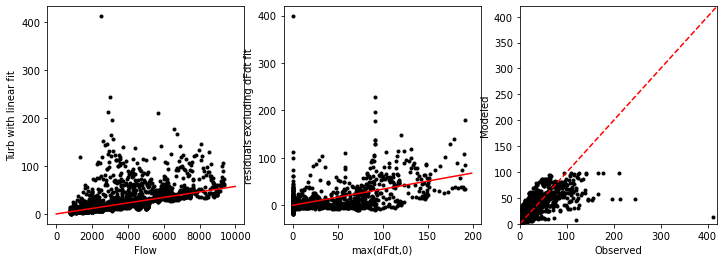

In [37]:
iTu=Tu[1:]; iF2=F2[1:];
ii=(~np.isnan(iTu))&(~np.isnan(iF2)&(~np.isnan(dFdt)))
dFdtP=np.array([max(iv,0) for iv in dFdt])
a=np.vstack([iF2[ii],dFdtP[ii],np.ones(len(iTu[ii]))]).T
m = np.linalg.lstsq(a,iTu[ii],rcond=None)[0]
print(m)
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(F2,Tu,'k.')
ax[0].plot(np.arange(0,11000,1000),m[0]*np.arange(0,11000,1000)+m[1],'r-')
ax[0].set_xlabel('Flow')
ax[0].set_ylabel('Turb with linear fit')
resid=iTu[ii]-np.dot(a,m)
SSE=np.sqrt(np.dot((iTu[ii]-np.dot(a,m)),(iTu[ii]-np.dot(a,m)).T)/len(iTu[ii]))
print(SSE)
resid2=iTu[ii]-(m[0]*iF2[ii]+m[2])
ax[1].plot(dFdtP[ii],resid2,'k.')
ax[1].set_xlabel('max(dFdt,0)')
ax[1].set_ylabel('residuals excluding dFdt fit')
ax[1].plot(np.arange(0,200),m[1]*np.arange(0,200),'r-')
ax[2].plot(iTu[ii],np.dot(a,m),'k.')
ax[2].set_xlim(0,420)
ax[2].set_ylim(0,420)
ax[2].set_xlabel('Observed')
ax[2].set_ylabel('Modeled')
ax[2].plot((0,420),(0,420),'r--');

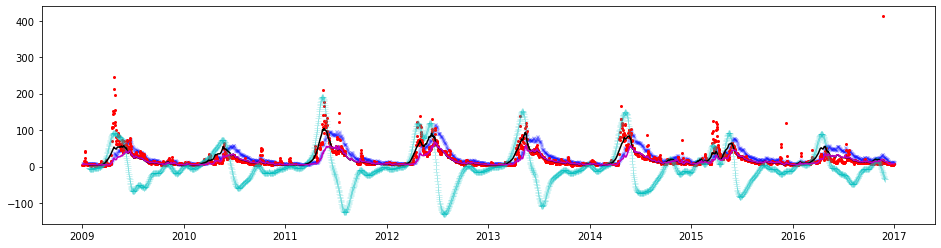

In [38]:
dFdt=(F2[1:]-F2[:-1])/(tt1[1:]-tt1[:-1])
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dts1,Fu*1e-2,'bx',ms=3,alpha=.2)
ax.plot(dts1,Tu,'ro',ms=2)
ax.plot(dts1[1:],dFdt,'c+',alpha=.2)
ax.plot(dts1[1:],m[0]*Fu[1:]+m[1]*dFdtP+m[2],'k-',ms=1)
ax.plot(dts1[1:],m1[0]*Fu[1:]+m1[1],'m-',ms=1);

### make turbidity files

In [44]:
# do calculations for 2002-2006
tstart=dt.datetime(2002,1,1)
tend=dt.datetime(2006,12,31)
df2=pd.DataFrame(session.query(FlowTBL.DecDay,FlowTBL.RateHope).\
                filter(and_(FlowTBL.DecDay>((tstart-dt.datetime(1900,1,1)).days-40),
                    FlowTBL.DecDay<=((tend-dt.datetime(1900,1,1)).days-40))).all())
df2.columns = ['DecDay', 'RateHope']

In [40]:
session.close()
engine.dispose()

In [41]:
def gsmooth3(times,Fvals,Tvals,L): # return same size array as inputs
    outtimes=np.arange(times[0],times[-1]+1)
    outvalsF=np.empty(np.shape(outtimes))
    outvalsT=np.empty(np.shape(outtimes))
    outwghtsF=np.empty(np.shape(outtimes))
    outwghtsT=np.empty(np.shape(outtimes))
    s=L/2.355
    sdict={}
    for ii in range(0,len(outtimes)):
        t=outtimes[ii]
        diff=[abs(x-t) for x in times]
        weight=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff]
        outvalsF[ii]=np.nansum(weight*Fvals)/np.sum(weight*np.array([int(i) for i in ~np.isnan(Fvals)]))
        outvalsT[ii]=np.nansum(weight*Tvals)/np.sum(weight*np.array([int(i) for i in ~np.isnan(Tvals)]))
        outwghtsF[ii]=np.sum(weight*np.array([int(i) for i in ~np.isnan(Fvals)]))
        outwghtsT[ii]=np.sum(weight*np.array([int(i) for i in ~np.isnan(Tvals)]))
        #summed weight of 5.3 seems like a good cutoff; close to max for L=5; use .99*max
    return(outtimes,np.where(outwghtsF>.99*np.max(outwghtsF),outvalsF,np.nan),np.where(outwghtsT>.99*np.max(outwghtsF),outvalsT,np.nan),outwghtsF,outwghtsT)

In [45]:
tt,F,T,wF,wT=gsmooth3(df2['DecDay'].values,df2['RateHope'].values,np.ones(np.shape(df2['RateHope'].values)),33)
dts=[dt.datetime(1900,1,1)+dt.timedelta(days=int(i)) for i in tt]

In [46]:
dFdt=(F[1:]-F[:-1])/(tt[1:]-tt[:-1])

In [47]:
df2['dFdt']=np.array([np.nan,]+[iel for iel in dFdt])

In [48]:
df2['dFdtP']=[max(ii,0) for ii in df2['dFdt']]

In [49]:
tt[0],df2['DecDay'][0]

(37216, 37216)

In [50]:
df2['estTurb']=m[0]*df2['RateHope']+m[1]*df2['dFdtP']+m[2]

Text(0, 0.5, 'Estimated Turbidity (NTU)')

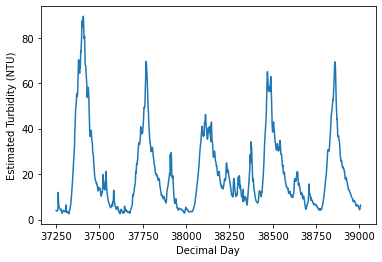

In [51]:
plt.plot(df2['DecDay'],df2['estTurb'])
plt.xlabel('Decimal Day')
plt.ylabel('Estimated Turbidity (NTU)')

### Create Files

In [52]:
def daterange(start_date, end_date): # end_date not included in range
    for n in range(int ((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

In [54]:
startdate=dt.datetime(2002,1,1)
enddate=dt.datetime(2006,12,31)
t=[el for el in daterange(startdate,enddate)]
t[-1]

datetime.datetime(2006, 12, 30, 0, 0)

In [55]:
f=nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2016m01d23.nc') # example for dims
fnamebase='/results/forcing/rivers/turbidity_est/riverTurbEst201909_'
startdate=dt.date(2002,1,1)
enddate=dt.date(2007,1,1)
for idate in daterange(startdate,enddate):
    iday=(idate-dt.date(1900,1,1)).days

    iTurb=df2.loc[df2.DecDay==iday,['estTurb']].values[0][0]
    if not iTurb>0:
        print('ERROR:',idate)
        break

    fname=fnamebase+idate.strftime('y%Ym%md%d')+'.nc'

    new=nc.Dataset(fname,'w')
    #Copy dimensions
    for dname, the_dim in f.dimensions.items():
        #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
        new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    # create dimension variables:
    new_x=new.createVariable('nav_lat',np.float32,('y','x'),zlib=True)
    new_x[:]=f.variables['nav_lat'][:,:]

    new_y=new.createVariable('nav_lon',np.float32,('y','x'),zlib=True)
    new_y[:]=f.variables['nav_lon'][:,:]

    new_tc=new.createVariable('time_counter',np.float32,('time_counter'),zlib=True)
    new_tc[:]=f.variables['time_counter'][:]
    
    new_run=new.createVariable('turb',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=-999.99 # most cells are masked with negative numbers
    new_run[:,400:448, 338:380]=iTurb # set turbidity to daily average
    new_run[:,440:503,363:398]=iTurb # extend Turbidity all the way up river

    new.close()

<ipython-input-55-22b58ed14028>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_x[:]=f.variables['nav_lat'][:,:]
<ipython-input-55-22b58ed14028>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_y[:]=f.variables['nav_lon'][:,:]
<ipython-input-55-22b58ed14028>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. 

ERROR: 2006-10-20


<ipython-input-55-22b58ed14028>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_x[:]=f.variables['nav_lat'][:,:]
<ipython-input-55-22b58ed14028>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_y[:]=f.variables['nav_lon'][:,:]
<ipython-input-55-22b58ed14028>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. 

In [56]:
ftest=nc.Dataset('/results/forcing/rivers/turbidity_est/riverTurbEst201909_y2003m01d01.nc')

In [57]:
ftest

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(398), y(898), time_counter(1)
    variables(dimensions): float32 nav_lat(y, x), float32 nav_lon(y, x), float32 time_counter(time_counter), float64 turb(time_counter, y, x)
    groups: 

<ipython-input-58-d016a98ee818>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.pcolormesh(ftest.variables['turb'][0,:,:])


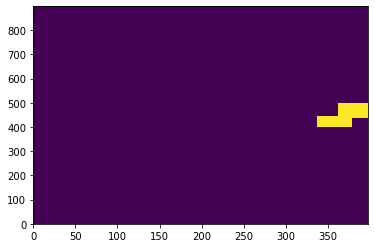

In [58]:
plt.pcolormesh(ftest.variables['turb'][0,:,:])

In [59]:
ftest.variables['turb'][0,410:425,364:368]

<ipython-input-59-68f316a11536>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ftest.variables['turb'][0,410:425,364:368]


masked_array(
  data=[[2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082],
        [2.65510082, 2.65510082, 2.65510082, 2.65510082]],
  mask=False,
  fill_value=1e+20)

In [60]:
ftest.close()